In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import root_mean_squared_error
import warnings
# 忽略 FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

plt.rcParams['font.family'] = "Arial"
# 保证能在Ai内编辑
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


### 定义函数

In [3]:
def calculate_error(y_true, y_pred):
    """
    计算预测值和真实值之间的相关系数（R）、平均偏差误差（MBE）、
    百分比平均偏差误差（%MBE）、均方根误差（RMSE）和百分比均方根误差（%RMSE）。

    参数:
    y_true: np.array, 真实值
    y_pred: np.array, 预测值

    返回:
    dict: 包含R, MBE, %MBE, RMSE, %RMSE的字典
    """
    Uo = 5
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # 相关系数 R
    R, _ = pearsonr(y_true, y_pred)
    # 计算误差
    error = y_pred - y_true
    # 平均偏差误差（MBE）
    MBE = np.mean(error)
    # 百分比平均偏差误差（%MBE）
    MBE_percent = (MBE / np.mean(y_true)) * 100
    # 均方根误差（RMSE）
    RMSE = root_mean_squared_error(y_true, y_pred)
    # 百分比均方根误差（%RMSE）
    RMSE_percent = (RMSE / np.sqrt(np.mean(y_true**2))) * 100
    # U95
    U95 = np.sqrt(Uo**2 + MBE_percent**2 + RMSE_percent**2)

    # return U95
    return {
        "R": round(R, 3),
        "MBE": round(MBE, 3),
        # "%MBE": MBE_percent,
        "RMSE": round(RMSE, 3),
        # "%RMSE": RMSE_percent,
        "U95": round(U95, 3)
    }

In [4]:
# 读取数据库
database = pd.read_feather(r"D:\PhD\data\station_feather\station_data_all_v3.feather").rename(columns={'daily_radiation':'Observation', "MERRA2":"MERRA-2"})
station_data = pd.read_excel(r"D:\PhD\data\station_all_v3.xlsx")[["originalID", "LULC_name"]]
# 添加土地覆盖类型字段
database = pd.merge(database, station_data, on="originalID", how="left" ).rename(columns={'LULC_name':'LC'})
# drop没用的字段
database = database.drop(columns=["originalID", "stationIndex", "date", "lat", "lon"])

Bare: {'R': 0.924, 'MBE': 5.457, 'RMSE': 30.789, 'U95': 13.342}
Built: {'R': 0.916, 'MBE': 10.155, 'RMSE': 33.562, 'U95': 17.862}
Crops: {'R': 0.947, 'MBE': 6.025, 'RMSE': 31.591, 'U95': 16.651}
Flooded vegetation: {'R': 0.956, 'MBE': -5.523, 'RMSE': 30.983, 'U95': 14.42}
Grass: {'R': 0.945, 'MBE': 5.0, 'RMSE': 32.748, 'U95': 17.418}
Shrub: {'R': 0.952, 'MBE': 0.905, 'RMSE': 29.314, 'U95': 13.37}
Snow&ice: {'R': 0.972, 'MBE': 0.448, 'RMSE': 28.649, 'U95': 18.002}
Trees: {'R': 0.947, 'MBE': 4.283, 'RMSE': 32.641, 'U95': 17.634}
Water: {'R': 0.887, 'MBE': -3.211, 'RMSE': 42.353, 'U95': 20.688}


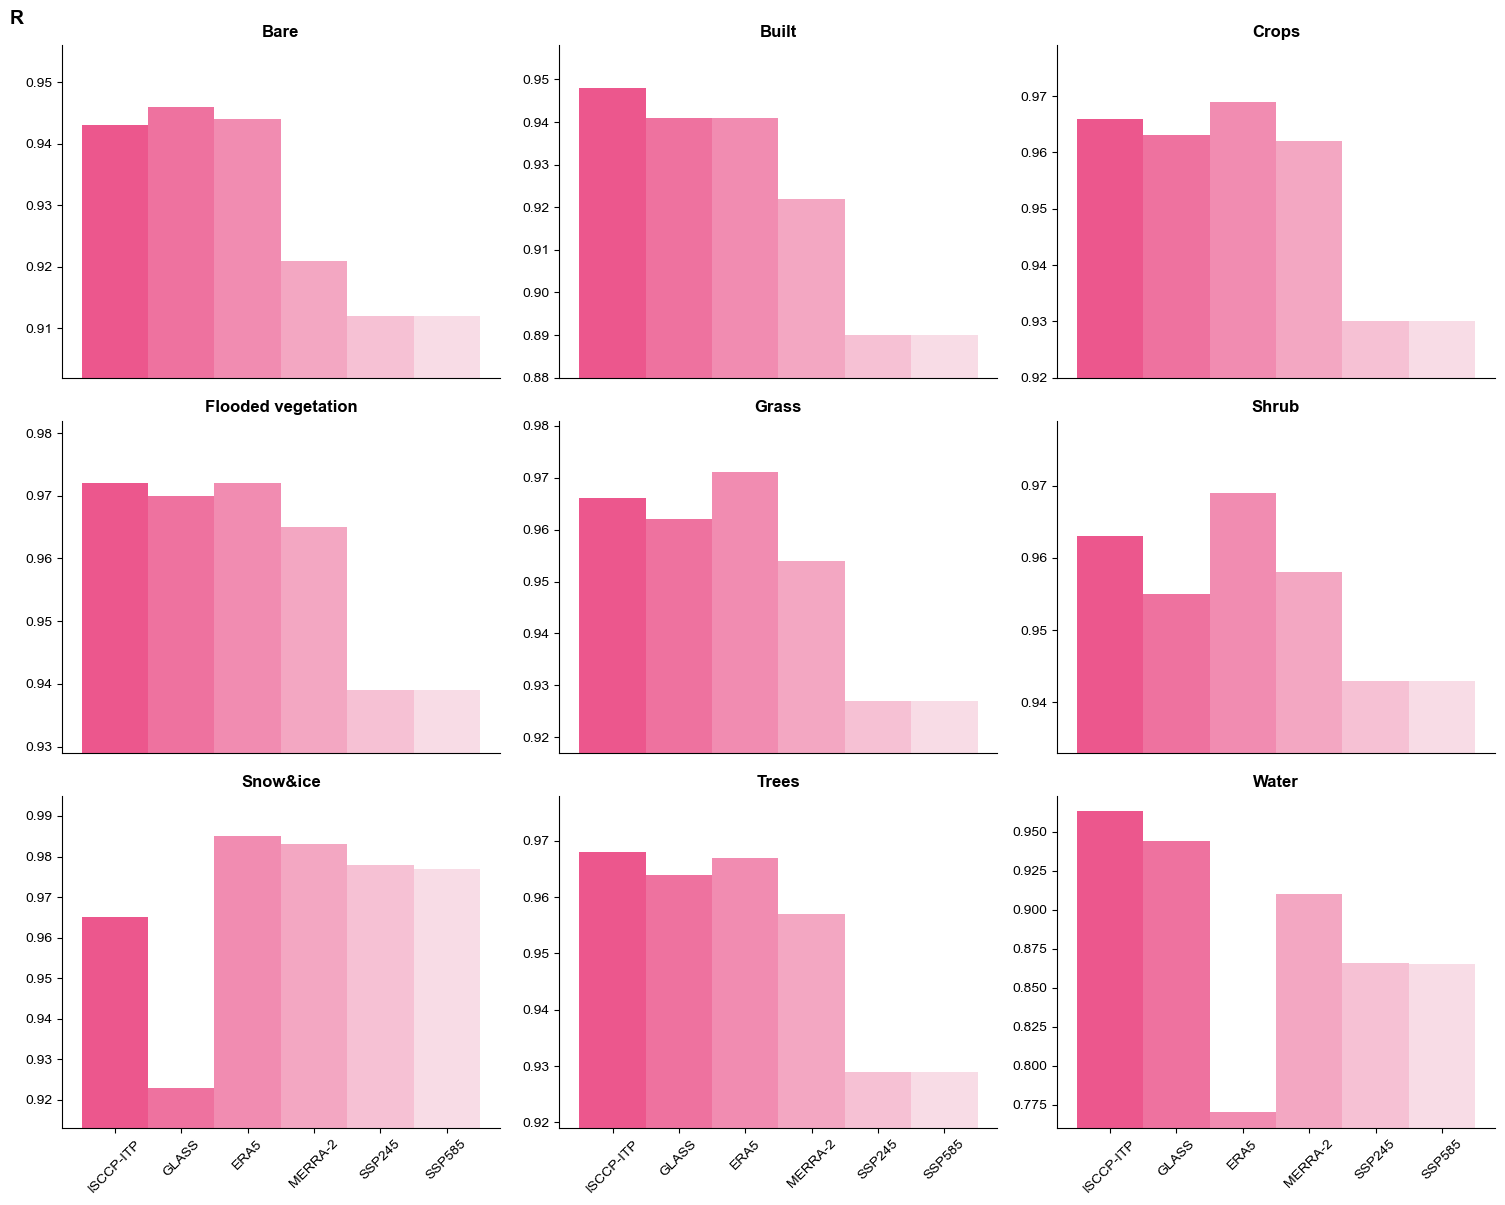

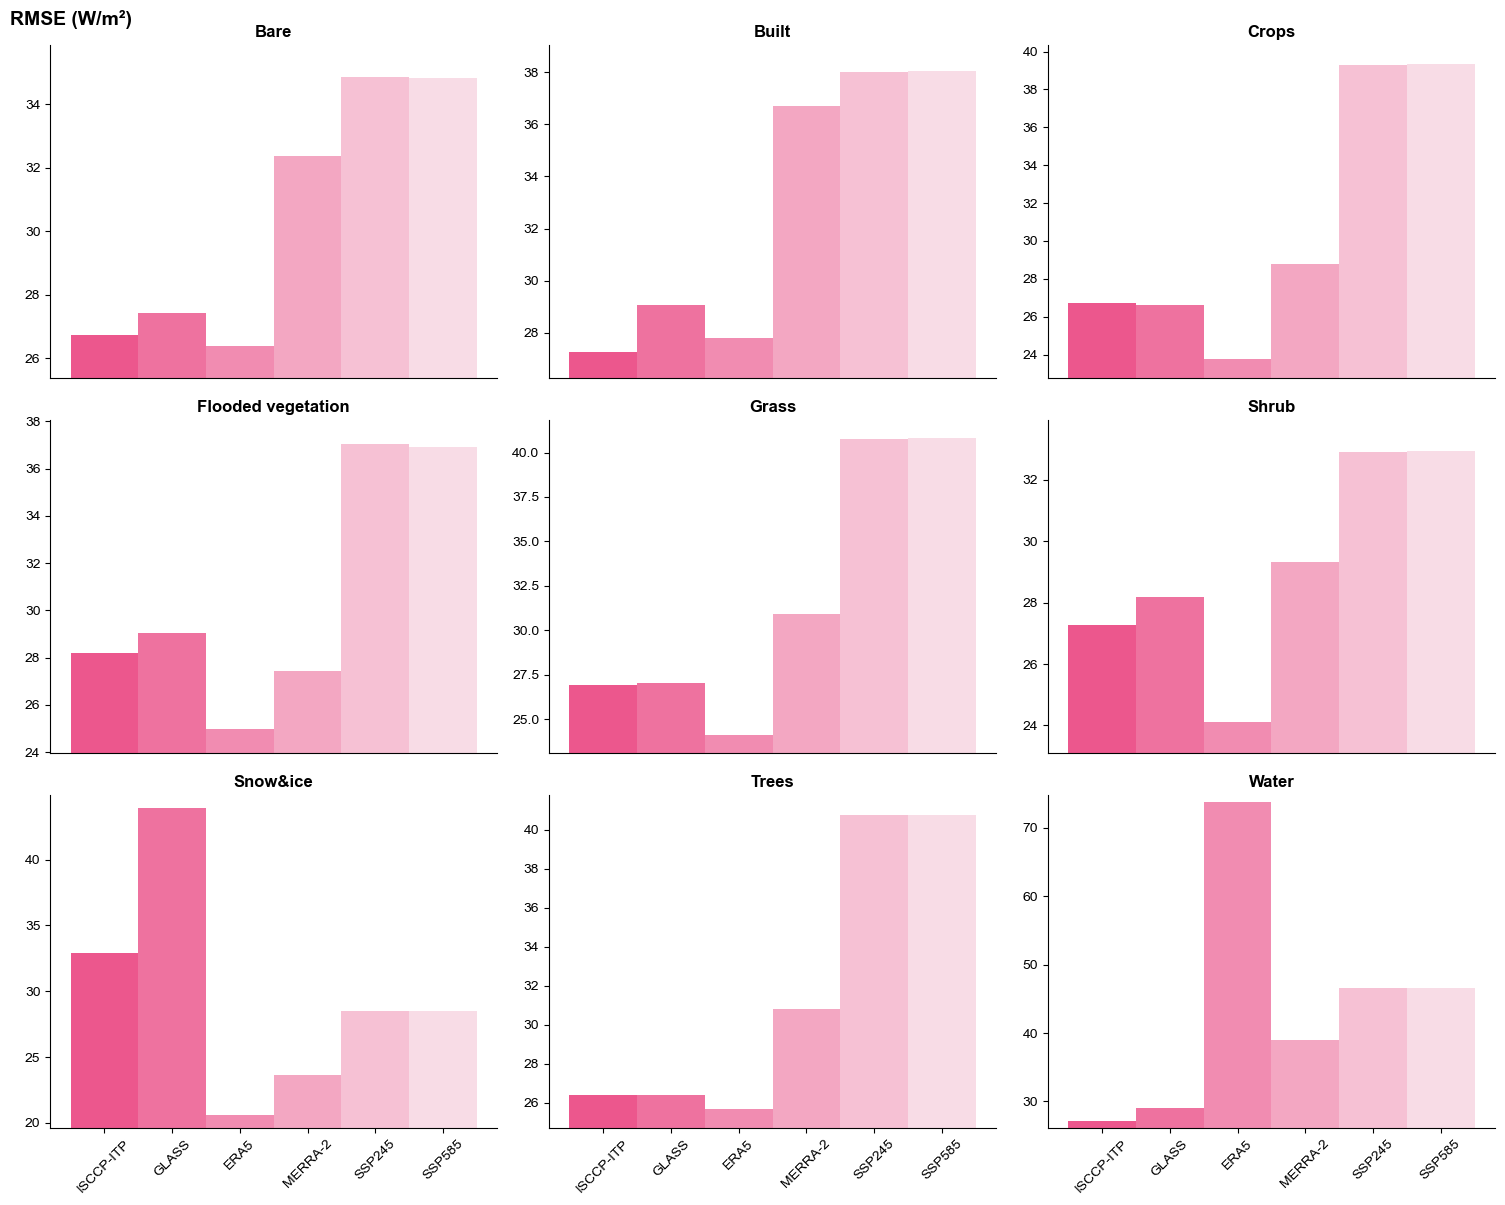

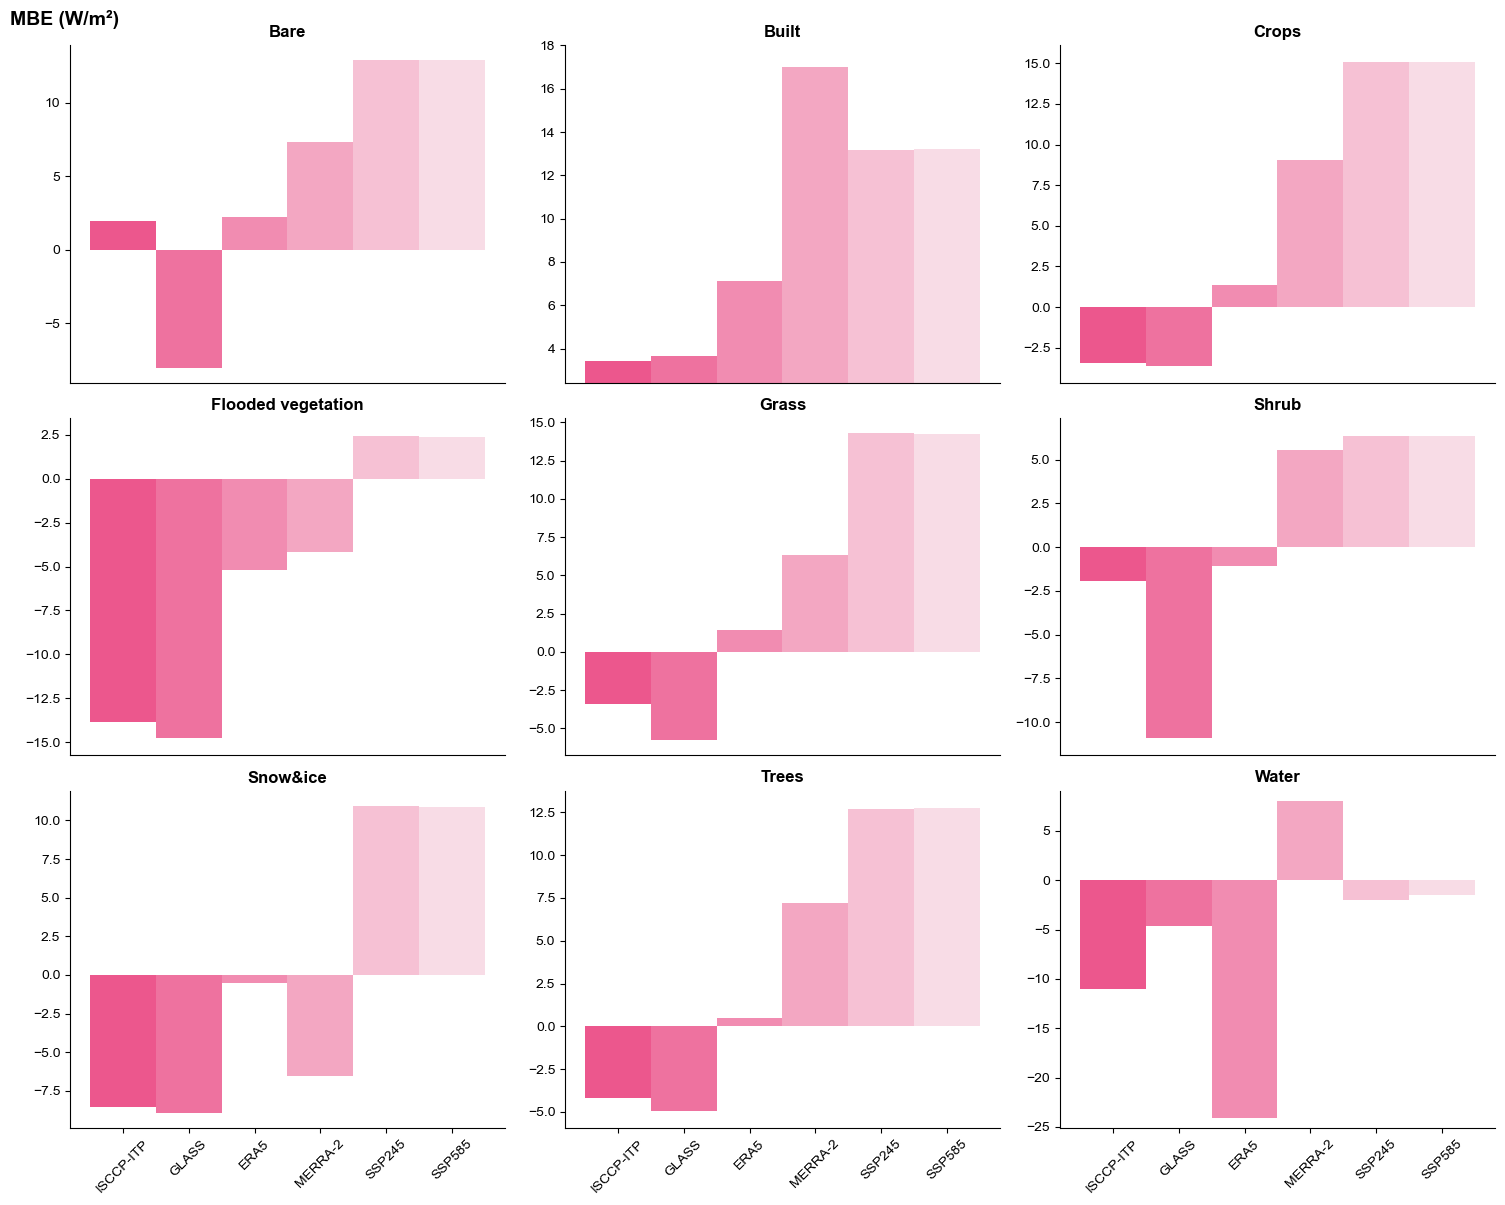

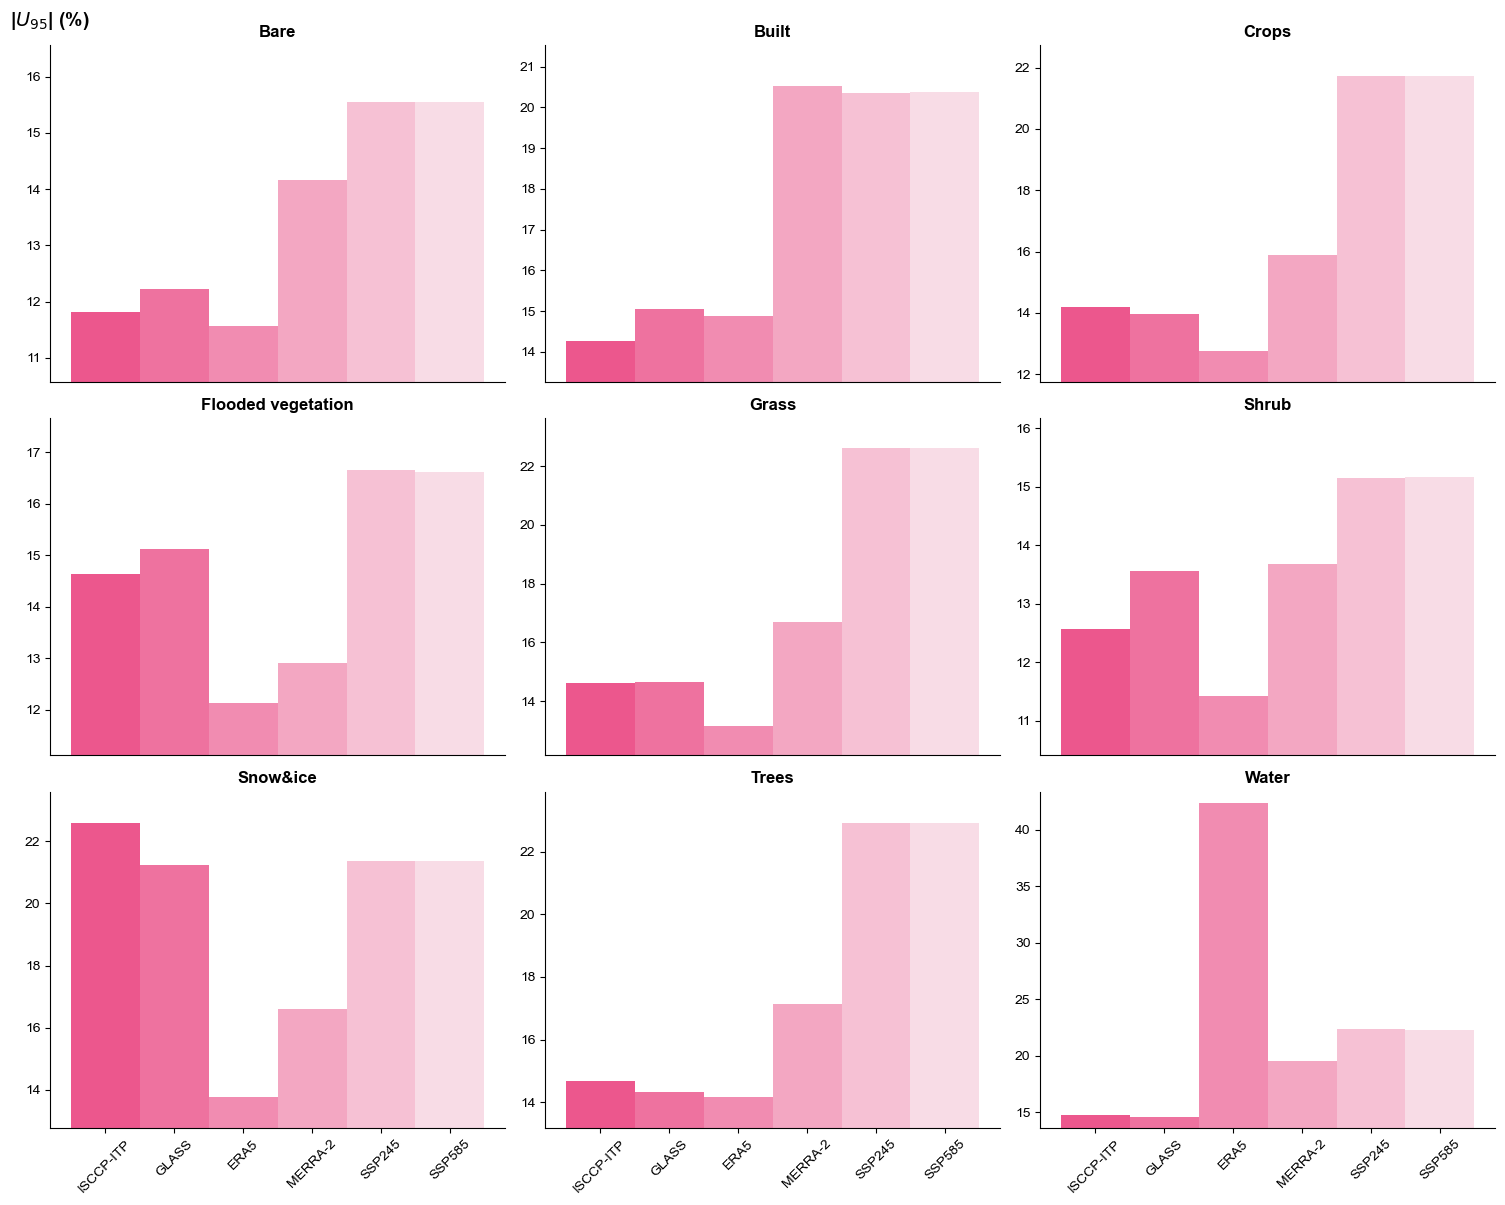

In [6]:
# 获取所有不同的土地覆盖类型
land_cover_types = database['LC'].unique()
land_cover_types.sort()  # 确保类型有序

# 数据产品列名
product_columns = ['ISCCP-ITP', 'GLASS', 'ERA5', 'MERRA-2', 'SSP245', 'SSP585']

# 定义每种产品对应的颜色
# colors = ['#ec578d', '#f186ad', '#f8c5d8', '#cae1f7', '#87bced', '#4397e3'] #SHAP色
# colors = colors[::-1] # 反转颜色顺序
colors = ['#ec578d', '#ee729f', '#f18cb1', '#f3a7c2', '#f6c1d4', '#f8dce6']

# 定义要绘制的指标
metrics = ["R", "RMSE", "MBE", "U95"]

# 为每个指标绘制一个 3x3 的子图布局
for metric in metrics:
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))

    # 遍历每种土地覆盖类型
    for i, lc_type in enumerate(land_cover_types):
        # 计算子图的行和列索引
        row = i // 3
        col = i % 3

        # 筛选出当前土地覆盖类型的数据
        lc_data = database[database['LC'] == lc_type]
        # 初始化当前lc_type的所有数据
        lc_type_data = pd.DataFrame(columns=["Observation", "Productions"])
        # 计算每种数据产品与观测值的误差
        errors = []

        for column in product_columns:
            lc_data_filter = lc_data[~lc_data[column].isna()][["Observation", column]].reset_index(drop=True)
            # 计算当前LC下，当前产品的误差
            error_dict = calculate_error(lc_data_filter['Observation'], lc_data_filter[column])
            # 正确从字典中提取所需指标的值
            errors.append(error_dict[metric])
            # 计算当前LC下，所有产品的误差
            lc_data_filter_temp = lc_data_filter.rename(columns={column:'Productions'})
            # 将数据添加到lc_type_data中
            lc_type_data = pd.concat([lc_type_data, lc_data_filter_temp])

        # 只打印一次即可
        if metric == "R":
            lc_type_error_dict= calculate_error(lc_type_data['Observation'], lc_type_data["Productions"])
            print(f"{lc_type}: {lc_type_error_dict}")



        # 设置Y轴刻度范围
        if metric == "R":
            vmax = np.max(errors)+0.01
            vmin = np.min(errors)-0.01
        else:
            vmax = np.max(errors)+1
            vmin = np.min(errors)-1

        # 在对应的子图上绘制柱状图，设置每种柱子的颜色
        axes[row, col].bar(product_columns, errors, color=colors, width=1)
        axes[row, col].set_title(f'{lc_type}', fontweight="bold")
        axes[row, col].tick_params(axis='x', rotation=45)
        axes[row, col].set_ylim(vmin, vmax)

        # 添加值标签
        # for j, error in enumerate(errors):
        #     axes[row, col].text(j, error, f'{error:.2f}', ha='center', va='bottom')

        # 取消右侧和上侧的坐标边框
        axes[row, col].spines['right'].set_visible(False)
        axes[row, col].spines['top'].set_visible(False)

        if row < 2:
            axes[row, col].axes.xaxis.set_visible(False)

    # 调整子图之间的间距
    plt.tight_layout()
    if metric in ["RMSE", "MBE"]:
        metric_unit = f"{metric} (W/m²)"
    elif metric == "U95":
        metric_unit = r"|$U_{95}$| (%)"
    else:
        metric_unit = "R"

    plt.suptitle(f'{metric_unit}', x=0, y=1, ha='left', fontweight='bold', fontsize=14)
    # 保存为矢量
    plt.savefig(f'figs/11柱状图组9x9-{metric}.pdf', format='pdf', dpi=1000, bbox_inches='tight')
    # plt.savefig(f'figs/11柱状图组9x9-{metric}.png', format='png', dpi=1000, bbox_inches='tight')
    plt.show()